In [62]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from collections import namedtuple as nt


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test
x_train

array([[ 0.45267141, -1.42381257],
       [ 0.61696406, -0.00418956],
       [-1.80708012, -1.34499648],
       ...,
       [ 0.63107723, -0.4743162 ],
       [-0.47320722, -0.6387028 ],
       [ 1.07909424, -1.67541279]])

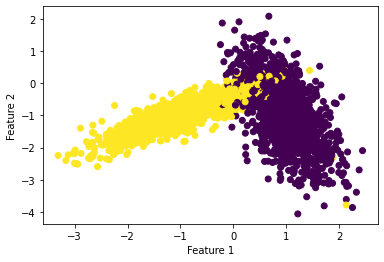

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(x_test[:,0], x_test[:,1],c=y_test,)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [67]:
# ----- GlOBALS ----

PARAM_CNT = 10 #num of k to be test upon
TRAIN_SCORE = 'TrainScore'
TEST_SCORE = 'TestScore'
HYPER_PARAM = 'HyperParam'

SearchInfo = nt('SearchInfo', [TRAIN_SCORE, TEST_SCORE, HYPER_PARAM])

# ------ IMPL ------

def randomSearch(x_train, y_train, classifier, params_range, folds):
    '''
    :param x_train: data points
    :param y_train: label points
    :param classifier: classifier model used to train data
    :param params_range: boundary for param val  
                         | format :- tuple (l, u) // lower & uper bound { inclusive both }
                         | (eg K val lower & uper bound for KNN classification)
    :param folds: number of folds to perform (ie number of buckets to divide data in)
    
    :return : namedtuple obj of train score, test score, hyper params
    '''
    train_scores = []
    test_scores = []

    # As x_train & y_train have equal number of rows
    size = len(y_train)

    # 1. get random values for K
    l, u = params_range
    assert l < u, "l must be smaller than u"
    d = u-l+1
    k = d if d < PARAM_CNT else PARAM_CNT
    # k vals = hyper - params in case of KNN
    hyper_params = random.sample(range(l, u+1), k) # pick k random uniform values from range [l, u]

    # 2. Bucketizing ie Creating groups
    groups = np.array_split(range(size) ,folds)
    grp_size = len(groups)

    # HYPER_PARAMS
    for k in tqdm(hyper_params):
        #!info indices -> fold number & val -> metric found in that fold
        train_scores_folds = []  # train scores for different folds ie grps combination
        test_scores_folds = []  # test scores for different folds ie grp combinations
        
        # CURRENT {k} ENTER
        
        # FOLDS
        for i in range(grp_size):  
            # 3. Find the test & train indices for current fold
            test_idx = groups[i]
            # chain the indexes into single group
            train_idx = [idx for gi in range(grp_size) if gi != i for idx in groups[gi]]

            '''
                # NOTE :- when pass arr[[idx1, idx2, idx3]] 
                # in case of n-dimen array ie with multiple axis
                # it will first flaten/ravel the matrix & then 
                # select val present at 3 idxes ie {idx1, idx2, idx3} from single vector
            '''
            # selecting the data points based on the train_indices and test_indices
            X_train = x_train[train_idx]
            Y_train = y_train[train_idx]
            X_test  = x_train[test_idx]
            Y_test  = y_train[test_idx]

            # 4. Train Model for current fold {i} & hyper-param {k} 
            classifier.n_neighbors = k
            classifier.fit(X_train,Y_train)

            Y_predicted = classifier.predict(X_test)
            test_scores_folds.append(accuracy_score(Y_test, Y_predicted))

            Y_predicted = classifier.predict(X_train)
            train_scores_folds.append(accuracy_score(Y_train, Y_predicted))
        
        # Current {k} EXIT
        # at the end of each hyper-param calc append result to final result list 

        #! score will be avg val found for all folds
        train_scores.append(np.mean(np.array(train_scores_folds)))
        test_scores.append(np.mean(np.array(test_scores_folds)))
        
    #return train_scores, test_scores
    return SearchInfo(train_scores, test_scores, hyper_params)

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

[16, 12, 4, 21, 6, 10, 5, 14, 23, 3]
[0.9548, 0.9544, 0.9505333333333335, 0.9541333333333334, 0.9510666666666667, 0.9526666666666667, 0.9495999999999999, 0.9545333333333333, 0.9533333333333333, 0.9464]
Speculated K :-  16


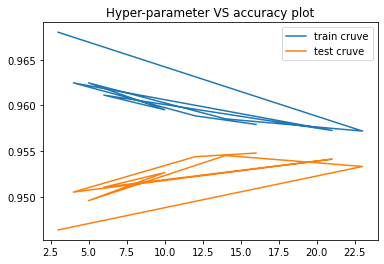

In [99]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")



knn_classif = KNeighborsClassifier()

#params = {'n_neighbors':[3,5,7,9,11,13,15,17,19,21,23]}
boundary = (3, 23)
folds = 3

info = randomSearch(x_train, y_train, knn_classif, boundary, folds)

trainscores = info.TrainScore
testscores = info.TestScore
hyperparams = info.HyperParam

print(hyperparams)
print(testscores)

trainerrors = 1 - np.array(trainscores, dtype=int)
testerrors = 1 - np.array(testscores, dtype=int)

# approximating the best k value

def error_overall(tr_err, ts_err):
    '''
    :param tr_err: - train error
    :param ts_err: - test error
    
    :return : float val indicating overall err from given errors
    '''
    # Error = bias + Variance^2.  
    # | & for bias we consider train dataset & for var we consider test dataset usually
    # | so providing more weight to testerror for better generalization
    
    return tr_err*100 + pow(ts_err*100, 2)
    #return tr_err + ts_err**2

idx = min(range(len(testerrors)), key=lambda i: error_overall(trainerrors[i], testerrors[i]))
optimal_k_speculate = hyperparams[idx]

print('Speculated K :- ', optimal_k_speculate)

plt.plot(hyperparams, trainscores, label='train cruve')
plt.plot(hyperparams, testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [100]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    # c_ means column stack so as to prepare data in format like (f1, f2)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

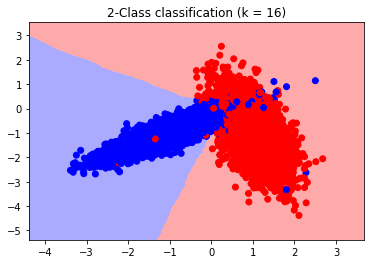

In [101]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = optimal_k_speculate)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

In [24]:
np.linspace(0, 10, 4, dtype=int, retstep=True, endpoint=False)

(array([0, 2, 5, 7]), 2.5)

In [15]:
10 / 3

3.3333333333333335

In [16]:
10 // 3

3

In [17]:
100 // 6

16

In [22]:
10 / 5

2.0

In [25]:
len(X_train)

7500

In [29]:
np.array_split(range(101),

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 array([ 68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100])]

In [31]:
a1 = np.array(range(100))

In [32]:
a1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [34]:
k = a1[[0, 2, 3, 10]]

In [35]:
k[0]

0

In [36]:
k[1]

2

In [37]:
k[4]

IndexError: index 4 is out of bounds for axis 0 with size 4

In [38]:
k[3]

10

In [39]:
a2 = np.array(range(20))

In [48]:
a2.reshape((2,5,2))

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9]],

       [[10, 11],
        [12, 13],
        [14, 15],
        [16, 17],
        [18, 19]]])

In [49]:
t2 = a2[[0, 10]]

In [50]:
t2[1]

10

In [51]:
a2.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [52]:
a2.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [71]:
l = 1 - t2

In [73]:
print(l)

[ 1 -9]
